<h1>Classifying news based on their content</h1>

<ol><b>
    <li>Vectorizing text data</li>
    <li>Dimensiality reduction</li>
    <li>Training classifiers</li>
</b></ol> 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score
import razdel
import pymorphy2

In [2]:
np.random.seed(42)
pd.set_option('max_colwidth', 120)

<h1>Data</h1>

In [6]:
df = pd.read_csv('fakenews_dataset.csv');

In [5]:
df.head()

,fake,content
0,1,Во Франции при поддержке министерства культуры стартуют съёмки кинокартины о Второй мировой войне под рабочим назван...
1,1,"Китайская провинция Цзянси, по решению ЦК КПК, станет пилотным регионом страны, в котором буде целиком ликвидировано..."
2,1,Государственная корпорация «Роскосмос» официально объявила об отказе ремонтировать сломанный в декабре 2017 года туа...
3,1,В компании Nestle категорически отказались пересматривать рецептуру своего детского питания и кондитерских изделий в...
4,1,Австрийская неправительственная общественная организация «Честь это верность» наградила сборную Хорватии по футболу ...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9174 entries, 0 to 9173
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   fake     9174 non-null   int64 
 1   content  9174 non-null   object
dtypes: int64(1), object(1)
memory usage: 143.5+ KB


In [8]:
print(df['fake'].value_counts(), '\n')
print(df['fake'].value_counts(normalize=True))

0    8340
1     834
Name: fake, dtype: int64 

0    0.909091
1    0.090909
Name: fake, dtype: float64


In [9]:
print('Fake')
print((df[df['fake'] == 1]['content'].apply(len)).agg([np.min, np.max, np.mean, np.median]), '\n')

print('Not fake')
print((df[df['fake'] == 0]['content'].apply(len)).agg([np.min, np.max, np.mean, np.median]))

Fake
amin       361.000000
amax      8521.000000
mean      1110.172662
median     981.000000
Name: content, dtype: float64 

Not fake
amin       306.000000
amax      4393.000000
mean      1342.651918
median    1271.000000
Name: content, dtype: float64


<h1>Vectorization</h1>

In [10]:
morph = pymorphy2.MorphAnalyzer(result_type=None)
def lemmatize(word):
    return morph.normal_forms(word)[0]

def tokenize(text):
    return [lemmatize(token.text) for token in razdel.tokenize(text)]
        
# class DenseTransformer(TransformerMixin):
#     def fit(self, X, y=None, **fit_params):
#         return self

#     def transform(self, X, y=None, **fit_params):
#         return X.todense()

In [11]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=0.0001, max_df=1.0)  # with min_df = 0.001: 9647 terms;;; 0.0005: 15256;;; 1: 59767
tfidf_docs = vectorizer.fit_transform(df['content'])

In [13]:
len(vectorizer.stop_words_)

0

In [14]:
tfidf_docs.shape

(9174, 59712)

<h1>Dimensiality reduction (LSA)</h1>

In [15]:
from sklearn.decomposition import TruncatedSVD

In [16]:
def get_MSE(reconstructed_tfidf, tfidf_docs):
    return np.sqrt(((tfidf_docs.toarray() - reconstructed_tfidf).flatten()**2).mean()).round(4)

In [24]:
errors = []

params = [25, 50, 100, 150, 200]

for param in params:
    lsa = TruncatedSVD(n_components=param, n_iter=5, random_state=42)
    dtm = lsa.fit_transform(tfidf_docs)
    reconstructed_tfidf = lsa.inverse_transform(dtm)
    error = get_MSE(reconstructed_tfidf, tfidf_docs)
    errors.append(error)

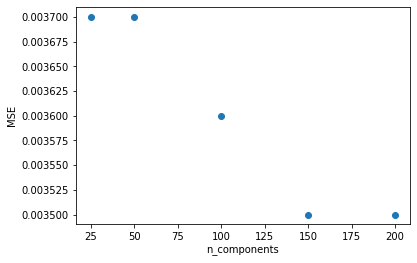

In [25]:
from matplotlib import pyplot as plt

plt.ylabel('MSE')
plt.xlabel('n_components')
plt.scatter(params, errors)

In [17]:
lsa = TruncatedSVD(n_components=25, n_iter=5, random_state=42)

<h1>Classification</h1>

<h1>Baseline Model</h1>

In [ ]:
# Baseline model - Zero rule classifier
# has accuracy 0.91
# but 0 precision

In [26]:
X_train, X_test, y_train, y_test = train_test_split(dtm, df['fake'], 
                                                    test_size=0.4, random_state=42)

<h1>Logistic regression</h1>

In [6]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr_clf = LogisticRegression(class_weight={1: 10})
lr_clf.fit(X_train, y_train)

In [ ]:
lr_clf.score(X_test, y_test)

In [ ]:
prediction_lr = lr_clf.predict(X_test)
prediction_lr[prediction_lr < 0] = 0
prediction_lr[prediction_lr > 0] = 1

print(f'Recall: {recall_score(y_test, prediction_lr)}')
print(f'F1: {f1_score(y_test, prediction_lr)}')

<h1>SVC</h1>

In [27]:
from sklearn.svm import SVC

In [ ]:
svc_clf = SVC(kernel='rbf', random_state=42, class_weight={1: 10})

In [ ]:
svc_clf.fit(X_train, y_train)

In [ ]:
svc_clf.score(X_test, y_test)

In [ ]:
prediction_svc = svc_clf.predict(X_test)

print(f'Recall: {recall_score(y_test, prediction_svc)}')
print(f'F1: {f1_score(y_test, prediction_svc)}')

<h1>Random Forest</h1>

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100, class_weight={1: 10})

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
rf.score(X_test, y_test)

In [ ]:
prediction_rf = rf.predict(X_test)
print(f'Recall: {recall_score(y_test, prediction_rf)}')
print(f'F1: {f1_score(y_test, prediction_rf)}')

<h1>Pipelines</h1>

In [28]:
from sklearn.pipeline import Pipeline

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['fake'], test_size=0.4, random_state=42)
X_full = np.hstack((X_train, X_test))

In [30]:
class TrainTestTransformer(TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
        self.train = True

    def fit(self, X, y=None, rs=42, train=True, **fit_params):
        if train:
            self.train = True
        self.X_train, self.X_test = train_test_split(X, test_size=0.4, shuffle=False, random_state=rs)
        return self

    def transform(self, X, y=None, **fit_params):
        if self.train:
            self.train = False
            return self.X_train
        else:
            return self.X_test

In [35]:
estimators = [('vectorize', TfidfVectorizer(tokenizer=tokenize, min_df=1, max_df=1.0)), 
              ('reduce_dim', TruncatedSVD(n_components=25, random_state=42)),
              ('train_test_split', TrainTestTransformer()), 
              ('clf', SVC(kernel='rbf', class_weight={1: 10}))]

pipe = Pipeline(estimators, verbose=True)

In [36]:
pipe.fit(X_full, y_train)

[Pipeline] ......... (step 1 of 4) Processing vectorize, total= 7.3min
[Pipeline] ........ (step 2 of 4) Processing reduce_dim, total=   1.2s
[Pipeline] .. (step 3 of 4) Processing train_test_split, total=   0.0s
[Pipeline] ............... (step 4 of 4) Processing clf, total=   0.1s


Pipeline(steps=[('vectorize',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x000001B914137D38>)),
                ('reduce_dim', TruncatedSVD(n_components=25, random_state=42)),
                ('train_test_split',
                 <__main__.TrainTestTransformer object at 0x000001B91D1F7D88>),
                ('clf', SVC(class_weight={1: 10}))],
         verbose=True)

In [37]:
pred = pipe.predict(X_test)

In [38]:
print(f'Accuracy: {accuracy_score(y_test, pred):.4f}')
print(f'Recall:   {recall_score(y_test, pred):.4f}')
print(f'F1:       {f1_score(y_test, pred):.4f}')

Accuracy: 0.9975
Recall:   0.9753
F1:       0.9875


<h1>Model selection with Grid Search</h1>

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
param_grid = dict(reduce_dim__n_components=[25, 50, 100, 200],
                  clf=[LogisticRegression(class_weight={1: 10}), SVC(kernel='rbf', class_weight={1: 10}), 
                       SVC(kernel='linear', class_weight={1: 10}), 
                       SVC(kernel='sigmoid', class_weight={1: 10}), 
                       RandomForestClassifier(n_estimators=100, class_weight={1: 10}), 
                       RandomForestClassifier(n_estimators=150, class_weight={1: 10}), 
                       RandomForestClassifier(n_estimators=50, class_weight={1: 10})])

estimators = [('reduce_dim', TruncatedSVD(random_state=42)),
              ('clf', None)]

In [12]:
pipe = Pipeline(estimators)

grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring=['accuracy', 'recall', 'f1'], 
                           refit='recall', verbose=0)

In [13]:
for min_df in [0.0001, 0.0005, 0.001, 0.002]:
    vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=min_df, max_df=1.0)
    tfidf_docs = vectorizer.fit_transform(df['content'])
    X_train, X_test, y_train, y_test = train_test_split(tfidf_docs, df['fake'], test_size=0.4, random_state=42)
    grid_search.fit(X_train, y_train)
    print(f'\n\nVectorization with min_df = {min_df}')
    print(grid_search.best_estimator_.get_params())
    pred = grid_search.best_estimator_.predict(X_test)

    print(f'Accuracy: {accuracy_score(y_test, pred)}')
    print(f'Recall: {recall_score(y_test, pred)}')
    print(f'F1: {f1_score(y_test, pred)}')
    print('-'*100, '\n')



Vectorization with min_df = 0.0001
{'memory': None, 'steps': [('reduce_dim', TruncatedSVD(n_components=25, random_state=42)), ('clf', SVC(class_weight={1: 10}))], 'verbose': False, 'reduce_dim': TruncatedSVD(n_components=25, random_state=42), 'clf': SVC(class_weight={1: 10}), 'reduce_dim__algorithm': 'randomized', 'reduce_dim__n_components': 25, 'reduce_dim__n_iter': 5, 'reduce_dim__random_state': 42, 'reduce_dim__tol': 0.0, 'clf__C': 1.0, 'clf__break_ties': False, 'clf__cache_size': 200, 'clf__class_weight': {1: 10}, 'clf__coef0': 0.0, 'clf__decision_function_shape': 'ovr', 'clf__degree': 3, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__max_iter': -1, 'clf__probability': False, 'clf__random_state': None, 'clf__shrinking': True, 'clf__tol': 0.001, 'clf__verbose': False}
Accuracy: 0.9978201634877384
Recall: 0.9780821917808219
F1: 0.9889196675900276
---------------------------------------------------------------------------------------------------- 



Vectorization with min_df = 

<h1>Best classifier parameters</h1>
Vectorization with min_df = 0.0001<p></p>
{'memory': None, <br/>
 'steps': [<br/>
    ('reduce_dim', TruncatedSVD(n_components=25, random_state=42)),<br/>
    ('clf', SVC(class_weight={1: 10}))], <br/>
 'verbose': False, <br/>
 'reduce_dim': TruncatedSVD(n_components=25, random_state=42),<br/> 
 'clf': SVC(class_weight={1: 10}), <br/>
 'reduce_dim__algorithm': 'randomized', <br/>
 'reduce_dim__n_components': 25, <br/>
 'reduce_dim__n_iter': 5, <br/>
 'reduce_dim__random_state': 42, <br/>
 'reduce_dim__tol': 0.0, <br/>
 'clf__C': 1.0, <br/>
 'clf__break_ties': False,<br/> 
 'clf__cache_size': 200, 
 'clf__class_weight': {1: 10}, <br/>
 'clf__coef0': 0.0, <br/>
 'clf__decision_function_shape': 'ovr', <br/>
 'clf__degree': 3, <br/>
 'clf__gamma': 'scale', <br/>
 'clf__kernel': 'rbf', <br/>
 'clf__max_iter': -1, <br/>
 'clf__probability': False, <br/>
 'clf__random_state': None, <br/>
 'clf__shrinking': True, <br/>
 'clf__tol': 0.001, <br/>
 'clf__verbose': False}<br/>

<h3><b>Accuracy</b>: 0.9978201634877384<br/>
<b>Recall</b>: 0.9780821917808219<br/>
<b>F1</b>: 0.9889196675900276</h3>